In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
df = pd.read_csv('./data/listings_sept_22.csv')

In [65]:
# Chained assignment to work with raw data. Must turn price to float and get bathroom count from bathroom_text
data = (
    df[
        [
            "id",
            "latitude",
            "longitude",
            "room_type",
            "accommodates",
            "bedrooms",
            "beds",
            "price",
            # "availability_30",
            # "availability_60",
            # "availability_90",
            # "availability_365",
            "bathrooms_text",
        ]
    ]
    .astype({"room_type": "object"})
    .assign(
        price_float=lambda x: x.price.str.replace("[\$,]", "", regex=True).astype(
            "float"
        ),
        bathrooms_count=lambda x: x.bathrooms_text.str.extract("(\d+(?:\.\d+)?)")
        .fillna(0)
        .astype("float"),
        # year=lambda x: x.last_scraped.dt.year,
        # month=lambda x: x.last_scraped.dt.month,
        # day=lambda x: x.last_scraped.dt.day,
        # first_mo_occ=lambda x: (30 - x.availability_30),
        # second_mo_occ=lambda x: (60 - x.availability_60) - x.first_mo_occ,
        # third_mo_occ=lambda x: (90 - x.availability_90)
        # - x.first_mo_occ
        # - x.second_mo_occ,
        # month_1_revenue=lambda x: x.price_float * x.first_mo_occ,
        # month_2_revenue=lambda x: x.price_float * x.second_mo_occ,
        # month_3_revenue=lambda x: x.price_float * x.third_mo_occ,
        # total_90_day_revenue=lambda x: (90 - x.availability_90) * x.price_float,
    )
    .drop(columns=["bathrooms_text", "price"])
    .fillna(0)
)

In [66]:
initial_len = len(data)

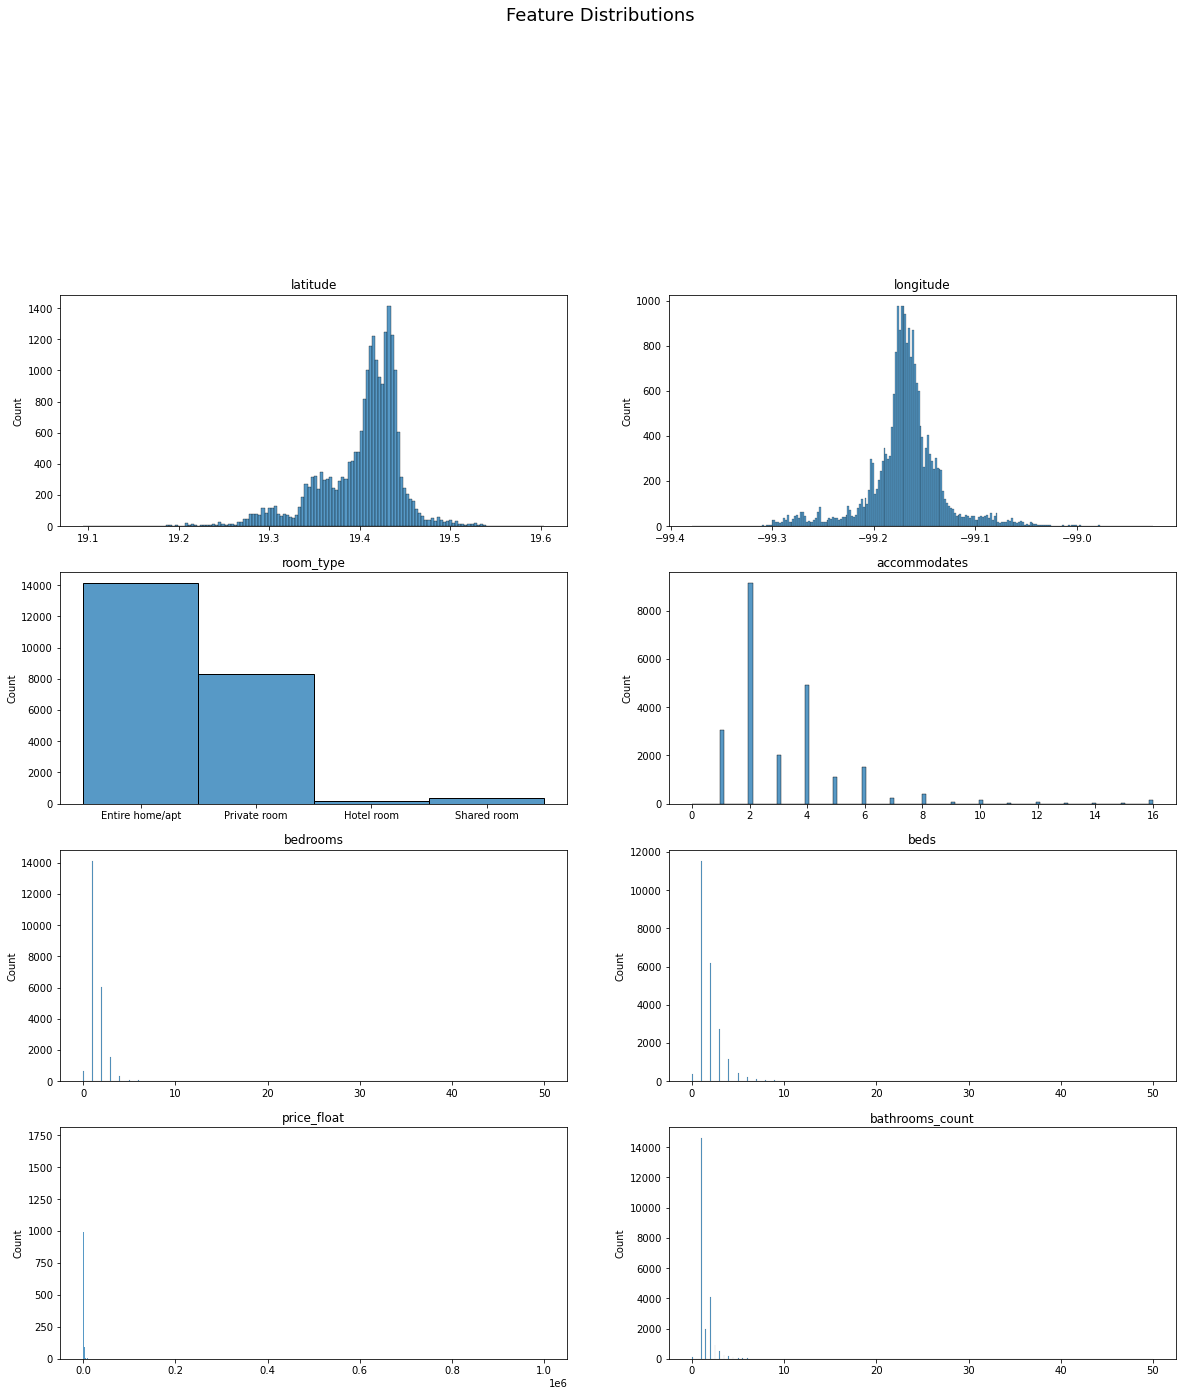

In [67]:
def plot_distributions(data):
    nums = data.select_dtypes(include=np.number)
    rows = len(data.columns)
    
    plt.figure(figsize=(20, 40))
    plt.suptitle("Feature Distributions", fontsize=18)
    for n, feature in enumerate(data.columns):
        ax = plt.subplot(rows, 2, n+1)
        sns.histplot(data=data, x=feature, ax=ax)

        ax.set_title(feature)
        ax.set_xlabel("")
    plt.show()
    pass

plot_distributions(data.drop(columns='id'))

In [68]:
def iqr(data, feature_list):
  upper_bounds = {}
  for feature in feature_list:
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = (q3 - q1)*1.5
    upper_bounds[feature] = q3 + iqr
  
  return upper_bounds

In [69]:
outliers = ['bedrooms', 'beds', 'bathrooms_count', 'price_float']
iqrs = iqr(data, outliers)

In [70]:
# Drop Outliers
for feature in outliers:
  data = data[data[feature] < iqrs[feature]]

In [71]:
print(f"Rows dropped: {initial_len - len(data)}")

Rows dropped: 3361


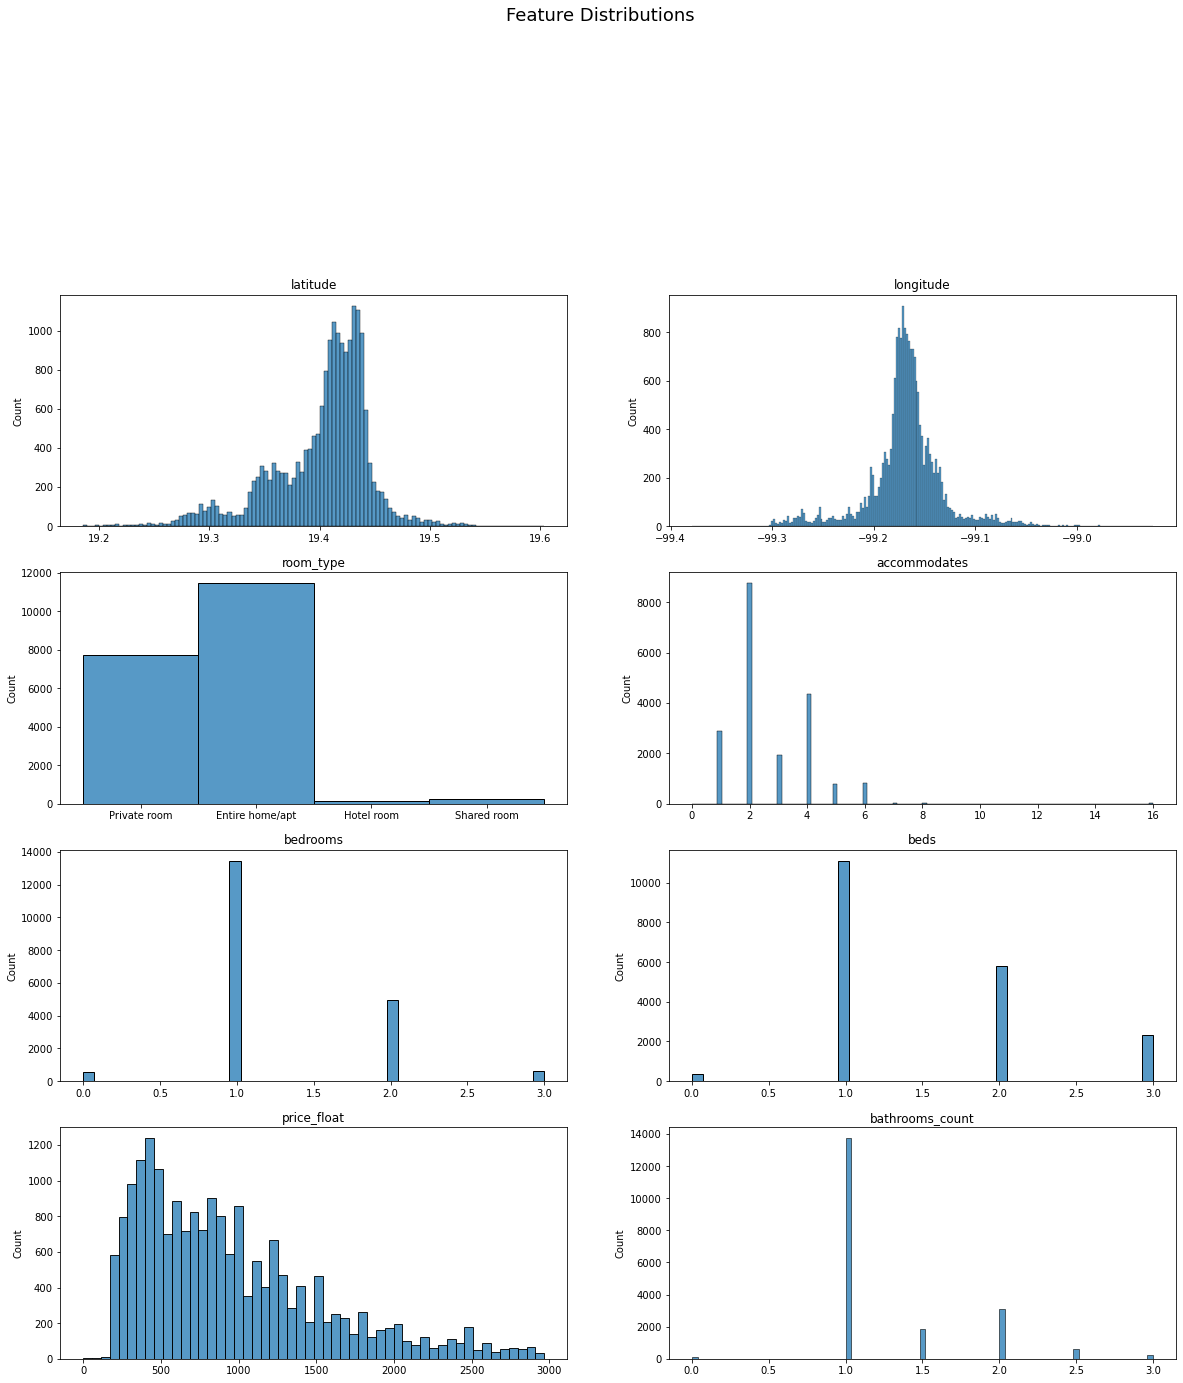

In [72]:
plot_distributions(data.drop(columns='id'))

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19587 entries, 2 to 22947
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               19587 non-null  int64  
 1   latitude         19587 non-null  float64
 2   longitude        19587 non-null  float64
 3   room_type        19587 non-null  object 
 4   accommodates     19587 non-null  int64  
 5   bedrooms         19587 non-null  float64
 6   beds             19587 non-null  float64
 7   price_float      19587 non-null  float64
 8   bathrooms_count  19587 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 2.0+ MB


## Clusters

In [74]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

ct = make_column_transformer(
    (
        StandardScaler(),
        [
            "latitude",
            "longitude",
            "accommodates",
            "bedrooms",
            "beds",
            "price_float",
            "bathrooms_count",
        ],
    ),
    (OneHotEncoder(), ["room_type"]),
    remainder="passthrough",
)

In [75]:
X = ct.fit_transform(data.drop(columns='id'))

In [76]:
# inertia_list = []

# for k in range(1, 51):
#     kmeans = KMeans(n_clusters=k, random_state=12)
#     kmeans.fit(X)
#     inertia_list.append(kmeans.inertia_)

# plt.plot(inertia_list, marker='o')
# plt.xlabel('# of Clusters')
# plt.ylabel('Score')
# plt.title('Inertia Scores');

In [77]:
# silhouette_list = []

# for k in range(2, 51):
#     kmeans = KMeans(n_clusters=k, random_state=12)
#     kmeans.fit(X)
#     silhouette_list.append(silhouette_score(X, kmeans.labels_))

# plt.plot(silhouette_list[:10], marker='o')
# plt.xlabel('# of Clusters')
# plt.ylabel('Score')
# plt.title('Silhouette Scores');

In [81]:
kmeans = KMeans(n_clusters=43, random_state=12)
kmeans.fit(X)

# dbscan = DBSCAN(eps=1, min_samples=50, n_jobs=-1)
# dbscan.fit(X)

# agg = AgglomerativeClustering(100)
# agg.fit(X)

k_sil_score = silhouette_score(X, kmeans.labels_)
# db_sil_score = silhouette_score(X, dbscan.labels_)
# agg_sil_score = silhouette_score(X, agg.labels_)

print(k_sil_score)

0.19158258872536177


In [17]:
data['cluster'] = kmeans.labels_

In [18]:
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

<AxesSubplot:>

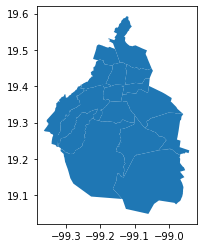

In [19]:
cdmx = gpd.read_file('data/nyu-2451-36860-shapefile/nyu_2451_36860.shp')
cdmx.plot()

In [20]:
cdmx.head()

,cvegeo,cve_ent,cve_mun,nomgeo,geometry
0,09002,09,002,Azcapotzalco,"POLYGON ((-99.18231 19.50748, -99.18229 19.507..."
1,09006,09,006,Iztacalco,"POLYGON ((-99.05584 19.42196, -99.05589 19.421..."
2,09009,09,009,Milpa Alta,"POLYGON ((-98.99723 19.22731, -98.99745 19.227..."
3,09010,09,010,Álvaro Obregón,"POLYGON ((-99.18871 19.39475, -99.18868 19.394..."
4,09013,09,013,Xochimilco,"POLYGON ((-99.09870 19.31964, -99.09849 19.319..."


In [21]:
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]

In [22]:
geo_df = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
geo_df.head()

/Users/andresperez/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,id,latitude,longitude,room_type,accommodates,bedrooms,beds,price_float,bathrooms_count,cluster,geometry
2,796477,19.41824,-99.17560,Private room,2,1.0,1.0,599.0,1.0,37,POINT (-99.17560 19.41824)
4,817291,19.38468,-99.17708,Entire home/apt,4,2.0,2.0,740.0,1.0,4,POINT (-99.17708 19.38468)
5,56074,19.43977,-99.15605,Entire home/apt,2,1.0,1.0,650.0,1.0,34,POINT (-99.15605 19.43977)
6,822005,19.40243,-99.17828,Entire home/apt,6,1.0,1.0,1441.0,1.0,26,POINT (-99.17828 19.40243)
7,58955,19.42113,-99.15955,Entire home/apt,2,1.0,1.0,1797.0,1.5,35,POINT (-99.15955 19.42113)


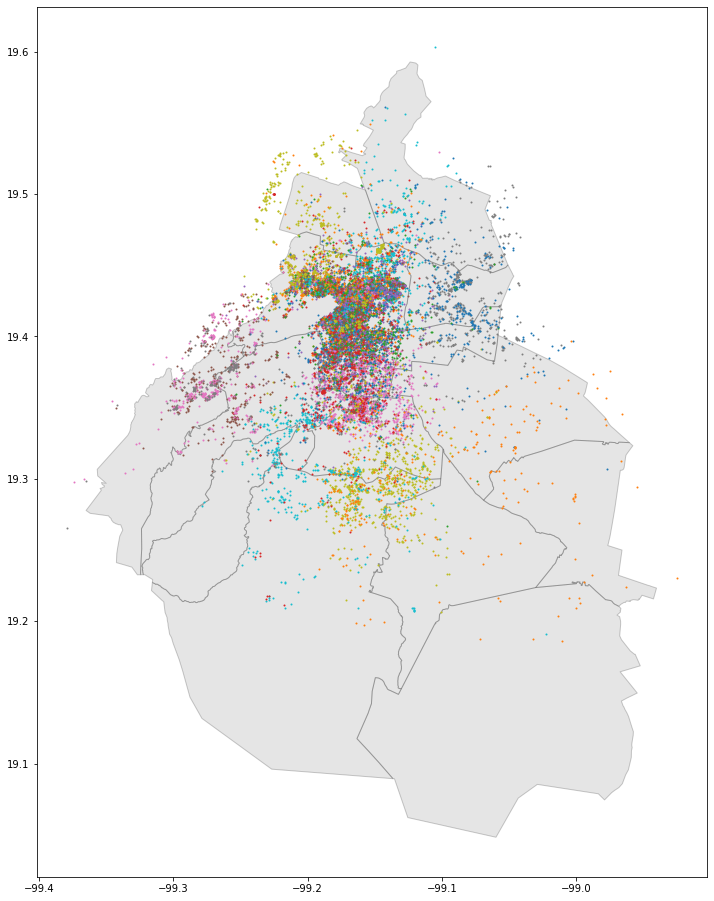

In [23]:

fig, ax = plt.subplots(figsize=(40,16))
cdmx.plot(ax=ax, alpha=.2, color='grey', edgecolor='black', legend=True)
for cluster in geo_df['cluster'].unique():
    geo_df[geo_df['cluster'] == cluster].plot(ax=ax, markersize=1)
    

In [24]:
clustered = pd.merge(
    left=data,
    right=df[
        [
            "id",
            "availability_30",
            "availability_60",
            "availability_90",
            "availability_365",
        ]
    ],
    how="left",
    on="id",
)

In [25]:
clustered

,id,latitude,longitude,room_type,accommodates,bedrooms,beds,price_float,bathrooms_count,cluster,geometry,availability_30,availability_60,availability_90,availability_365
0,796477,19.418240,-99.175600,Private room,2,1.0,1.0,599.0,1.0,37,POINT (-99.17560 19.41824),0,18,48,323
1,817291,19.384680,-99.177080,Entire home/apt,4,2.0,2.0,740.0,1.0,4,POINT (-99.17708 19.38468),0,10,39,314
2,56074,19.439770,-99.156050,Entire home/apt,2,1.0,1.0,650.0,1.0,34,POINT (-99.15605 19.43977),30,49,79,354
3,822005,19.402430,-99.178280,Entire home/apt,6,1.0,1.0,1441.0,1.0,26,POINT (-99.17828 19.40243),22,22,44,319
4,58955,19.421130,-99.159550,Entire home/apt,2,1.0,1.0,1797.0,1.5,35,POINT (-99.15955 19.42113),0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19582,610124362379692985,19.469490,-99.056830,Entire home/apt,2,1.0,1.0,390.0,1.0,38,POINT (-99.05683 19.46949),19,38,68,343
19583,697457011724147393,19.465703,-99.051118,Shared room,2,1.0,1.0,450.0,1.0,38,POINT (-99.05112 19.46570),30,60,90,365
19584,22175774,19.421690,-99.245990,Private room,2,2.0,1.0,750.0,1.0,12,POINT (-99.24599 19.42169),29,59,89,89
19585,45285491,19.427120,-99.224520,Entire home/apt,3,0.0,1.0,1100.0,1.0,33,POINT (-99.22452 19.42712),26,56,86,361


## Cluster on lat, long only

In [83]:
ct2 = make_column_transformer(
    (
        StandardScaler(),
        [
            "latitude",
            "longitude",
        ],
    ),
    remainder="passthrough",
)

In [84]:
X2 = ct2.fit_transform(data[['latitude', 'longitude']])

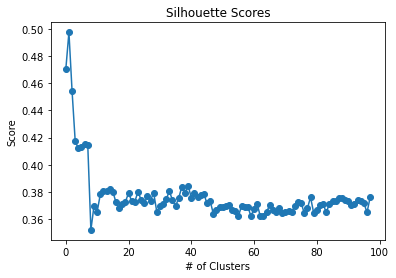

In [85]:
silhouette_list = []

for k in range(2, 100):
    kmeans = KMeans(n_clusters=k, random_state=12)
    kmeans.fit(X2)
    silhouette_list.append(silhouette_score(X2, kmeans.labels_))

plt.plot(silhouette_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores');

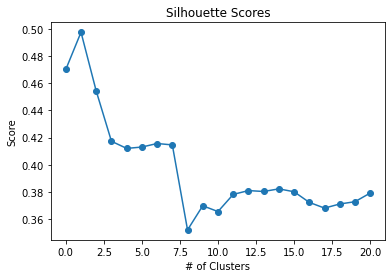

In [86]:
plt.plot(silhouette_list[:21], marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores');

In [87]:
kmeans2 = KMeans(n_clusters=7, random_state=12)
kmeans2.fit(X2)

KMeans(n_clusters=7, random_state=12)

In [88]:
data['cluster2'] = kmeans2.labels_

In [89]:
geo_df = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
geo_df.head()

/Users/andresperez/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,id,latitude,longitude,room_type,accommodates,bedrooms,beds,price_float,bathrooms_count,cluster2,geometry
2,796477,19.41824,-99.17560,Private room,2,1.0,1.0,599.0,1.0,1,POINT (-99.17560 19.41824)
4,817291,19.38468,-99.17708,Entire home/apt,4,2.0,2.0,740.0,1.0,5,POINT (-99.17708 19.38468)
5,56074,19.43977,-99.15605,Entire home/apt,2,1.0,1.0,650.0,1.0,0,POINT (-99.15605 19.43977)
6,822005,19.40243,-99.17828,Entire home/apt,6,1.0,1.0,1441.0,1.0,1,POINT (-99.17828 19.40243)
7,58955,19.42113,-99.15955,Entire home/apt,2,1.0,1.0,1797.0,1.5,1,POINT (-99.15955 19.42113)


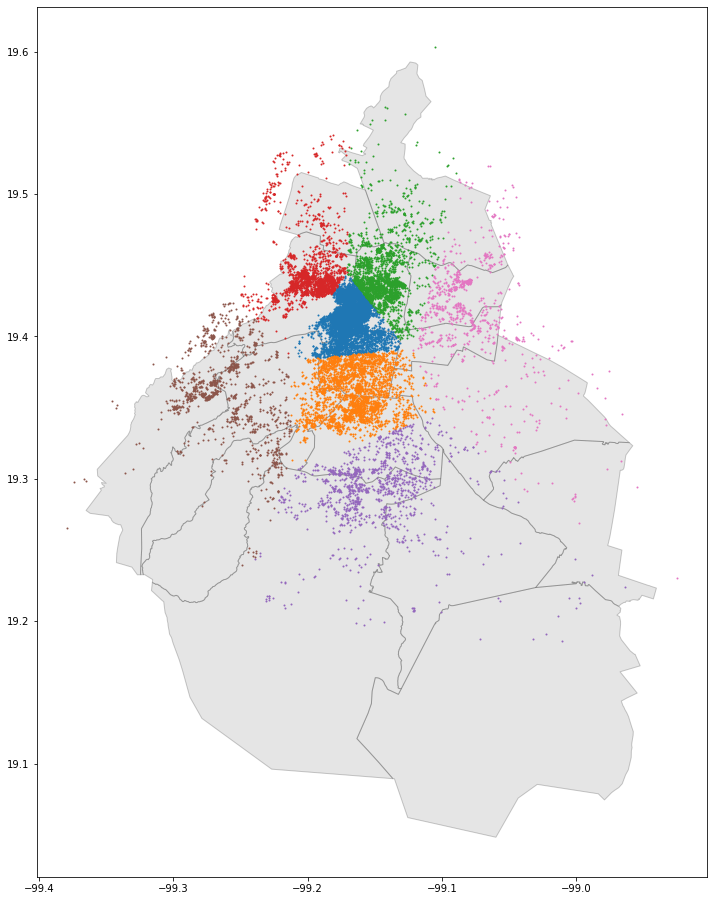

In [90]:

fig, ax = plt.subplots(figsize=(40,16))
cdmx.plot(ax=ax, alpha=.2, color='grey', edgecolor='black', legend=True)
for cluster in geo_df['cluster2'].unique():
    geo_df[geo_df['cluster2'] == cluster].plot(ax=ax, markersize=1)
    